<a href="https://colab.research.google.com/github/yaniv256/VAEs-in-Economics/blob/master/Notebooks/Covid_19_VAEs_counties.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-19 with VAEs

## Confirmed Covid-19 cases

### Data

#### Load it

In [1]:
!rm -rf us-counties.csv
!wget https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv

--2020-04-01 04:47:42--  https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 851003 (831K) [text/plain]
Saving to: ‘us-counties.csv’

us-counties.csv     100%[===================>] 831.06K  --.-KB/s    in 0.1s    

2020-04-01 04:47:43 (8.38 MB/s) - ‘us-counties.csv’ saved [851003/851003]



In [0]:
import pandas as pd
df = pd.read_csv('us-counties.csv')

In [3]:
df.index = ['{}, {}'.format(county,state) 
             for county, state in zip(df.county,df.state)]

df


,date,county,state,fips,cases,deaths
"Snohomish, Washington",2020-01-21,Snohomish,Washington,53061.0,1,0
"Snohomish, Washington",2020-01-22,Snohomish,Washington,53061.0,1,0
"Snohomish, Washington",2020-01-23,Snohomish,Washington,53061.0,1,0
"Cook, Illinois",2020-01-24,Cook,Illinois,17031.0,1,0
"Snohomish, Washington",2020-01-24,Snohomish,Washington,53061.0,1,0
...,...,...,...,...,...,...
"Sheridan, Wyoming",2020-03-30,Sheridan,Wyoming,56033.0,8,0
"Sublette, Wyoming",2020-03-30,Sublette,Wyoming,56035.0,1,0
"Sweetwater, Wyoming",2020-03-30,Sweetwater,Wyoming,56037.0,2,0
"Teton, Wyoming",2020-03-30,Teton,Wyoming,56039.0,17,0


In [4]:
import numpy as np

dates = np.unique(df.date)
dates.sort()
dates

array(['2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24',
       '2020-01-25', '2020-01-26', '2020-01-27', '2020-01-28',
       '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-01',
       '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05',
       '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-09',
       '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13',
       '2020-02-14', '2020-02-15', '2020-02-16', '2020-02-17',
       '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21',
       '2020-02-22', '2020-02-23', '2020-02-24', '2020-02-25',
       '2020-02-26', '2020-02-27', '2020-02-28', '2020-02-29',
       '2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
       '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
       '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
       '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16',
       '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
       '2020-03-21', '2020-03-22', '2020-03-23', '2020-

In [5]:
from collections import OrderedDict

confirmed = pd.DataFrame(OrderedDict((date, df.loc[df.date == date].cases)
                                     for date in dates)) 

confirmed[confirmed.isna()]=0

confirmed

,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30
"Abbeville, South Carolina",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,4.0,4.0,4.0,4.0,3.0
"Acadia, Louisiana",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,3.0,8.0,9.0,9.0,11.0
"Accomack, Virginia",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,3.0,6.0
"Ada, Idaho",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0,3.0,3.0,3.0,4.0,11.0,13.0,15.0,22.0,37.0,54.0,76.0,88.0,113.0,151.0
"Adair, Iowa",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"York, Virginia",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,3.0,3.0,5.0,5.0,6.0,8.0,9.0,9.0,9.0,9.0,11.0
"Young, Texas",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
"Yuba, California",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,6.0
"Yuma, Arizona",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,3.0,4.0,4.0,4.0,9.0,12.0


#### Create train-test split

In [6]:
from sklearn.model_selection import train_test_split 
x_train, x_test = train_test_split(confirmed, test_size=0.25, random_state=42)
confirmed = pd.concat([x_train,x_test], axis=0)

x_train.shape, x_test.shape

((1573, 70), (525, 70))

#### Transform to log(1+x)

In [0]:
from sklearn.model_selection import train_test_split 

x_train, x_test = train_test_split(confirmed, test_size=0.25, random_state=42)

confirmed = pd.concat([x_train,x_test], axis=0)

x = np.log(x_train.values + 1)
max_train_log = np.max(x) 
x /= max_train_log
x_train = pd.DataFrame(x,index=x_train.index, 
                       columns=x_train.columns)

x = np.log(x_test.values + 1)
x /= max_train_log
x_test = pd.DataFrame(x,index=x_test.index, 
                       columns=x_test.columns)

### Network

#### Build the VAE

In [8]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [9]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [0]:
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

def make_vae(input_shape):

  latent_dim = 1  
  dense_width = 1024

  input_x = keras.Input(shape=input_shape)

  x = layers.Dense(dense_width, activation='relu')(input_x)
  x = layers.Dense(dense_width, activation='relu')(x)
  x = layers.Dense(dense_width, activation='relu')(x)

  z_mean = layers.Dense(latent_dim)(x)
  z_log_var = layers.Dense(latent_dim)(x)

  encoder = Model(input_x, z_mean)

  def sampling(args):
      z_mean, z_log_var = args
      epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                                mean=0., stddev=1.)
      return z_mean + K.exp(z_log_var) * epsilon

  z = layers.Lambda(sampling)([z_mean, z_log_var])

  # This is the input where we will feed `z`.
  decoder_input = layers.Input(K.int_shape(z)[1:])

  # Upsample to the correct number of units
  x = layers.Dense(dense_width,activation='relu')(decoder_input)
  x = layers.Dense(dense_width,activation='relu')(x)
  x = layers.Dense(dense_width,activation='relu')(x)

  x = layers.Dense(input_shape[0])(x)

  # This is our decoder model.
  decoder = Model(decoder_input, x)

  # We then apply it to `z` to recover the decoded `z`.
  z_decoded = decoder(z)

  class CustomVariationalLayer(keras.layers.Layer):

      def vae_loss(self, x, z_decoded):
          xent_loss = keras.metrics.mse(x, z_decoded)
          kl_loss = -5e-4 * K.mean(
              1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
          return K.mean(xent_loss + kl_loss)

      def call(self, inputs):
          x = inputs[0]
          z_decoded = inputs[1]
          loss = self.vae_loss(x, z_decoded)
          self.add_loss(loss, inputs=inputs)
          # We don't use this output.
          return x

  # We call our custom layer on the input and the decoded output,
  # to obtain the final model output.
  y = CustomVariationalLayer()([input_x, z_decoded])

  vae = Model(input_x, y)
  vae.encoder = encoder
  vae.decoder = decoder

  return vae

#### Train it

In [11]:
from tensorflow import set_random_seed
from numpy.random import seed

seed(100)
set_random_seed(100)

vae = make_vae(input_shape=(x_train.shape[1],))

vae.compile(optimizer='adam', loss=None)

n_batch_sizes=7

history = ['']*n_batch_sizes
titles  = ['']*n_batch_sizes

# Train the VAE on boston housing data

for i in range(n_batch_sizes):

  # Alternate between a few epochs with large batch size (realiable decrease in 
  # loss but weak and overfitting) and a few epochs with small batch size
  # (strong and non-overfitting but could increase loss)
  batch_size = 512*(1-(i%2)) + 16*(i%2)
  epochs = 20*(1-(i%2)) + 60*(i%2)

  print('Batch size:', batch_size)
  titles[i] = 'Round {}, Batch size {}'.format(i+1, batch_size)

  history[i] = vae.fit(x=x_train, y=None,
                       shuffle=True,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=(x_test, None))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Batch size: 512
Train on 1573 samples, validate on 525 samples
Epoch 1/20
1573/1573 [==============================] - 1s 893us/sample - loss: 0.0057 - val_loss: 0.0046
Epoch 2/20
1573/1573 [==============================] - 0s 18us/sample - loss: 0.0041 - val_loss: 0.0033
Epoch 3/20
1573/1573 [==============================] - 0s 18us/sample - loss: 0.0029 - val_loss: 0.0025
Epoch 4/20
1573/1573 [==============================] - 0s 19us/sample - loss: 0.0029 - val_loss: 0.0024
Epoch 5/20
1573/1573 [==============================] - 0s 16us/sample - loss: 0.0027 - val_loss: 0.0030
Epoch 6/20
1573/1573 [==============================] - 0s 17us/sample - loss: 0.0029 - val_loss: 0.0030
Epoch 7/20
1573/1573 [==============================] - 0s 18us/sample - loss: 0.0027 - val_loss: 0.0028
Epoch 8/20
1573/1573 [==============================] - 0s 16us/sample - loss: 0.0029 - val_loss: 0.0025
Epoch 9/20
1573

#### Verify convergence

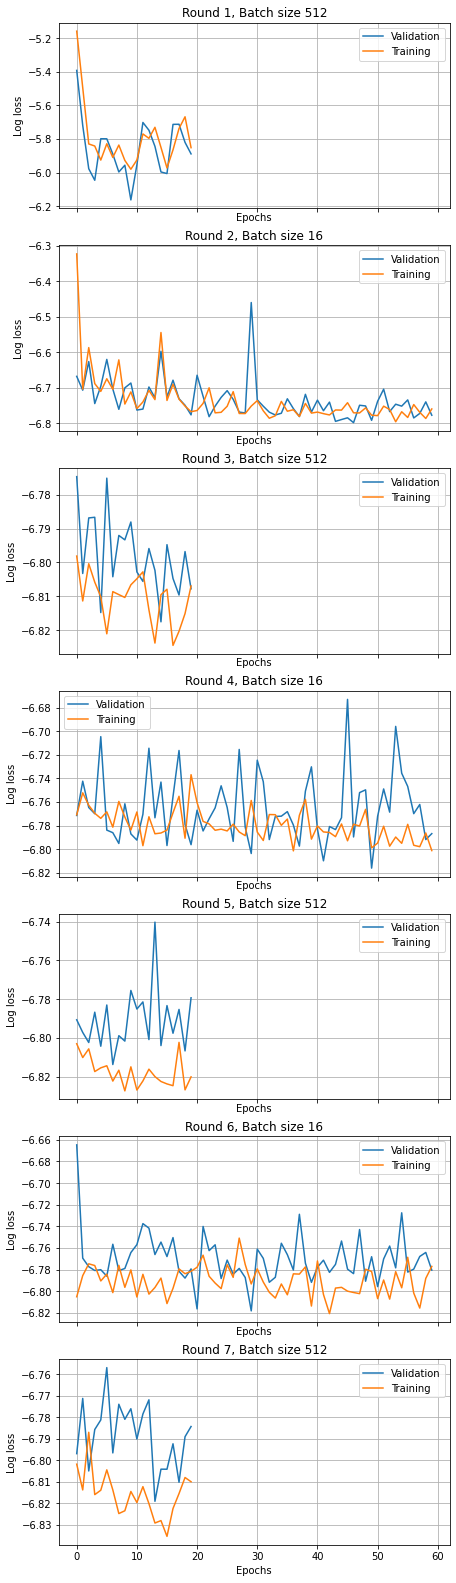

In [12]:
import matplotlib.pyplot as plt
import numpy as np

f, ax = plt.subplots(len(history), 1, figsize=(7, len(history)*4), sharex=True)

for i in range(len(history)):

  ax[i].set_title(titles[i])
  ax[i].plot(history[i].epoch, np.log(history[i].history['val_loss']), label='Validation')
  ax[i].plot(history[i].epoch, np.log(history[i].history['loss']), label='Training')
  ax[i].set_xlabel('Epochs')
  ax[i].set_ylabel('Log loss')
  ax[i].legend()
  ax[i].grid()

### Encoding

#### Encode the data

In [13]:
qt = pd.concat([x_train,x_test], axis=0)
qt.head()

,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30
"Bay, Michigan",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.065716,0.065716,0.065716,0.065716,0.065716,0.065716,0.065716,0.065716,0.065716,0.065716,0.065716,0.104157,0.131432,0.152587,0.152587,0.152587,0.169873,0.218303
"Westmoreland, Pennsylvania",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.104157,0.152587,0.152587,0.169873,0.184487,0.235589,0.268611,0.305175,0.325569,0.354360,0.367020,0.381635
"Mifflin, Pennsylvania",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.104157,0.104157
"Missaukee, Michigan",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.065716,0.065716,0.065716,0.065716,0.065716
"Mason, Washington",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.065716,0.065716,0.065716,0.065716,0.065716,0.065716,0.065716,0.104157,0.104157,0.104157,0.104157,0.104157,0.104157,0.104157


In [14]:
encoded_data=pd.DataFrame(vae.encoder.predict(qt),index=qt.index, columns=['Type'])
New_York_sign = np.sign(encoded_data.loc['New York City, New York','Type'])
if New_York_sign == 1.0:
  encoded_data['Type'] *= -1.0
New_York_sign, encoded_data.loc['New York City, New York','Type']

(-1.0, -2.7266557)

#### Compute types

In [15]:
min_x, max_x, grid_n = -3, 3, 401
grid_x = np.linspace(min_x,max_x,grid_n)
decoded=vae.decoder.predict(grid_x)
if New_York_sign == 1.0:
  decoded = np.flip(decoded,axis=0)
decoded.shape

(401, 70)

#### Explore the distribution of types

In [16]:
import seaborn as sns

def plot_type_dist(encoded_data, grid_x, decoded, vertical_n, 
                   feature_labels, n_grid_lines=21):

  fig = plt.figure(figsize=(10,vertical_n*2.5),constrained_layout=True)
  gs = fig.add_gridspec(vertical_n, 1)
  ax1 = fig.add_subplot(gs[0,:])
  ax2 = fig.add_subplot(gs[1:,:])

  min_x, max_x, grid_n = grid_x[0], grid_x[-1], len(grid_x)
  grid_lines = np.linspace(min_x,max_x,n_grid_lines)

  ax1.set_title('Encoded data distribution')
  sns.kdeplot(encoded_data,bw=0.02, shade = True, ax=ax1, gridsize=2000)
  ax1.set_xticks( grid_lines )
  ax1.set_xlim(min_x,max_x)
  ax1.grid(axis='x')

  ax2.set_title('Generated types')

  sns.heatmap(decoded.T,cmap='viridis',ax=ax2, cbar_kws={'orientation':'horizontal'})
  ax2.set_xticks(np.linspace(1,grid_n,n_grid_lines))
  ax2.set_xticklabels(['{:.2}'.format(a) for a in grid_lines ])
  ax2.set_yticklabels(feature_labels)
  ax2.tick_params(axis='y',labelright=True, labelleft=False, 
                  left=False, labelrotation=0)
  ax2.grid(axis='x')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


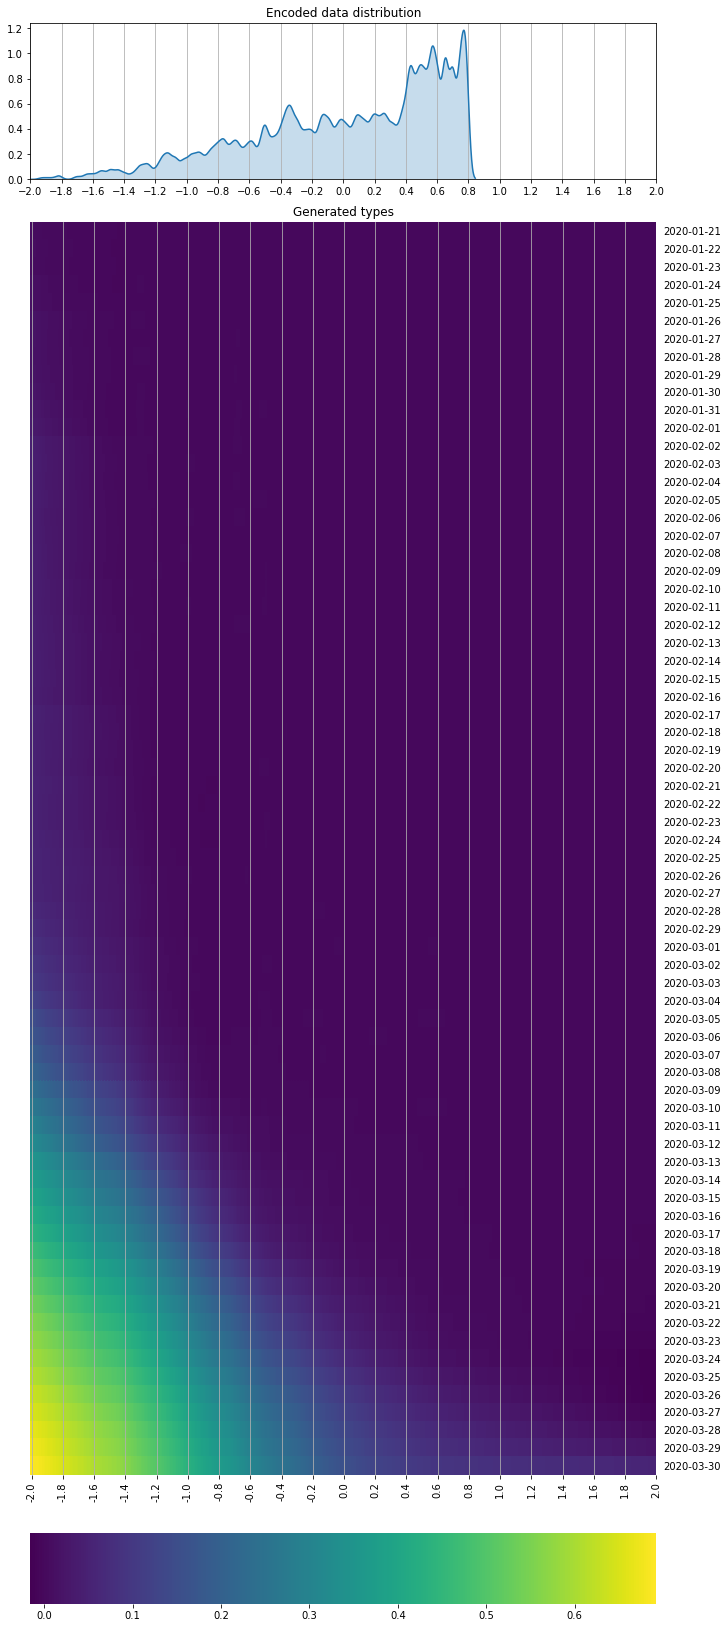

In [17]:
plot_type_dist(encoded_data.values.flatten(), grid_x, decoded, 
               vertical_n=9, feature_labels=qt.columns)

plt.savefig('plot_dist_type.png')

#### Explore encoding sorted data 

In [18]:
data = encoded_data.join(confirmed)

data = data.sort_values(by='Type')

data.to_csv('covid19_confirmed.csv')
data

,Type,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30
"New York City, New York",-2.726656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,4.0,5.0,12.0,14.0,20.0,37.0,52.0,96.0,155.0,269.0,330.0,464.0,645.0,1339.0,2468.0,4408.0,6211.0,9045.0,12305.0,14905.0,20011.0,23112.0,25399.0,30766.0,33768.0,38087.0
"Westchester, New York",-2.549999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,17.0,33.0,69.0,81.0,97.0,107.0,120.0,147.0,157.0,178.0,195.0,219.0,379.0,537.0,797.0,1091.0,1387.0,1873.0,2894.0,3891.0,4691.0,5944.0,7187.0,7875.0,8519.0,9326.0
"King, Washington",-2.526815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,11.0,15.0,22.0,33.0,52.0,59.0,72.0,91.0,117.0,191.0,235.0,271.0,329.0,389.0,421.0,489.0,518.0,563.0,693.0,794.0,935.0,1036.0,1166.0,1278.0,1360.0,1579.0,1830.0,2079.0,2163.0,2332.0
"Snohomish, Washington",-2.252315,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,3.0,5.0,8.0,17.0,18.0,26.0,36.0,45.0,61.0,69.0,107.0,132.0,154.0,175.0,199.0,265.0,309.0,347.0,384.0,446.0,480.0,518.0,613.0,633.0,778.0,913.0,912.0,1067.0,1126.0
"Nassau, New York",-2.206042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,5.0,17.0,19.0,28.0,41.0,51.0,79.0,98.0,109.0,131.0,183.0,382.0,754.0,1234.0,1900.0,2442.0,2869.0,3285.0,3914.0,4657.0,5537.0,6445.0,7344.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Archuleta, Colorado",0.783179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
"Rutherford, North Carolina",0.783179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
"Crawford, Missouri",0.783179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
"Jerome, Idaho",0.783179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [19]:
import re

Minnesota  = pd.DataFrame([data.loc[re.search('^.*Minnesota', index).group(0),:] 
                           for index in data.index 
                           if re.search('Minnesota', index)])
Minnesota[0:10]



,Type,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30
"Hennepin, Minnesota",-1.243456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,6.0,12.0,26.0,26.0,33.0,33.0,44.0,52.0,57.0,89.0,103.0,111.0,128.0,141.0,152.0,171.0,190.0
"Ramsey, Minnesota",-0.987429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,4.0,8.0,8.0,8.0,8.0,12.0,16.0,17.0,18.0,24.0,26.0,27.0,32.0,34.0,42.0,46.0,50.0
"Olmsted, Minnesota",-0.838070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,3.0,3.0,6.0,6.0,11.0,12.0,14.0,16.0,18.0,21.0,29.0,34.0,37.0,47.0,51.0
"Dakota, Minnesota",-0.830687,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,3.0,4.0,7.0,7.0,7.0,7.0,7.0,11.0,18.0,21.0,21.0,25.0,28.0,33.0,39.0,46.0
"Washington, Minnesota",-0.634270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,3.0,3.0,4.0,7.0,10.0,10.0,13.0,15.0,22.0,25.0,27.0,34.0
"Anoka, Minnesota",-0.603702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,3.0,3.0,5.0,5.0,5.0,5.0,7.0,7.0,7.0,8.0,10.0,12.0,17.0,22.0
"Martin, Minnesota",-0.582880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,3.0,4.0,5.0,8.0,8.0,8.0,10.0,12.0,18.0,19.0,21.0,23.0
"Carver, Minnesota",-0.483142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,3.0,3.0,8.0,8.0,8.0,8.0,8.0,8.0,9.0,9.0,10.0
"Mower, Minnesota",-0.393428,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,6.0,6.0,6.0,6.0,10.0,10.0,11.0,11.0,12.0
"Stearns, Minnesota",-0.378981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


In [0]:
def plot_by_code(data, center=(-5.0,5.0,0.2), width=0.2, max_n=10):
    centers = np.arange(*center)
    decoded_centers=vae.decoder.predict(centers)
    if New_York_sign == 1.0:
      decoded_centers = np.flip(decoded_centers,axis=0)
    decoded_dict = dict(zip(centers,decoded_centers.tolist()))
    sub_df=OrderedDict((centers[i], 
                        data.loc[(data['Type'] >= centers[i]-width/2)
                                  & (data['Type'] <= 
                                     centers[i] + width/2)].iloc[:,1:])
                       for i in range(len(centers)))
    sub_df = OrderedDict(filter(lambda x: len(x[1])>0, sub_df.items()))
    fig, ax = plt.subplots(1,len(sub_df), 
                           figsize = (5*len(sub_df),3.5), 
                           sharey=True)
    for i, center in zip(range(len(sub_df)),sub_df.keys()):
      if len(sub_df[center])>max_n:
        sample = np.random.choice(sub_df[center].shape[0],
                                  size=max_n,replace=False)
        sub_df[center] = sub_df[center].iloc[sample,:]
      sub_df[center]= sub_df[center]+1
      ax[i].plot(np.exp(np.array(decoded_dict[center])*max_train_log),'k')
      ax[i].plot(sub_df[center].T, alpha=0.4)
      ax[i].set_ylabel('Confirmed cases')
      ax[i].legend(['Type = {:.2f}'.format(center)] 
                    + sub_df[center].index.tolist(), bbox_to_anchor=(1, -0.3),
                   loc='upper right',borderaxespad=0.)
      ax[i].set_yscale('log')
      ax[i].set_title('Types {:.2f} to {:.2f}'.format(center - width/2,
                                                      center + width/2))
      ax[i].grid(True)
      ax[i].set_xticks(range(1,sub_df[center].shape[1],7))
      ax[i].tick_params(axis='x',labelrotation=45)

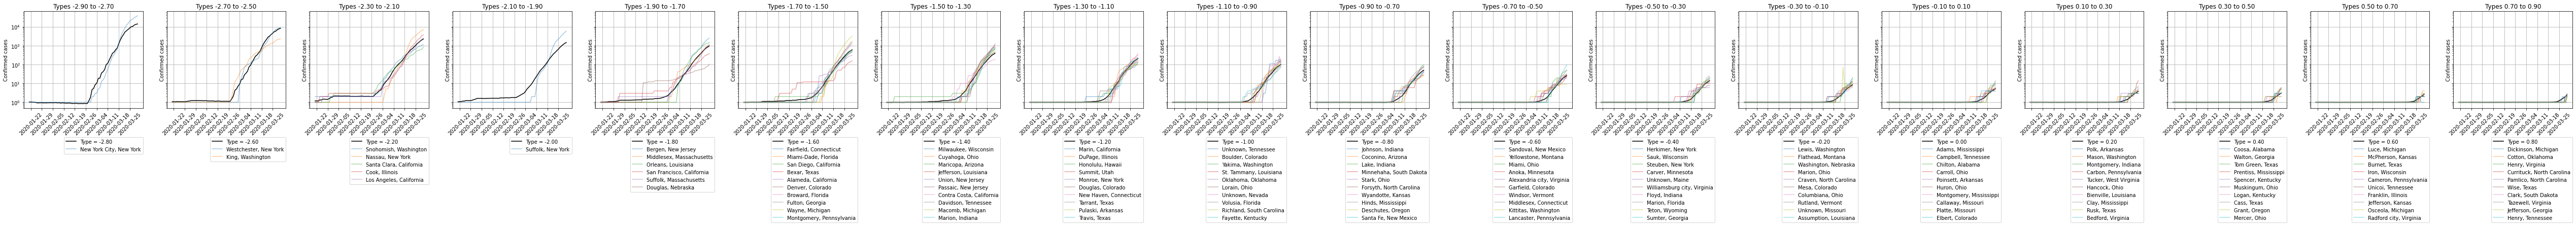

In [21]:
plot_by_code(data, max_n = 10)

plt.savefig('plot_by_code.png')

### Rate of change

#### Approximate as diff(log(1+x),7)

In [22]:
lag = 7
change = pd.DataFrame((np.log(data.iloc[:,1+lag:-1].values+1)
                      - np.log(data.iloc[:,1:-1-lag].values+1))/lag,
                      index = data.index,
                      columns = data.columns[1+lag:-1])
change

,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29
"New York City, New York",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.099021,0.099021,0.156945,0.156945,0.229920,0.255966,0.366421,0.287843,0.335911,0.362711,0.410240,0.423610,0.465442,0.433353,0.442010,0.442502,0.404745,0.461448,0.462408,0.477364,0.447974,0.472566,0.467972,0.448389,0.386237,0.319512,0.250157,0.228566,0.188174
"Westchester, New York",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.328941,0.412910,0.503766,0.606928,0.629531,0.654995,0.668876,0.356172,0.300977,0.219462,0.134127,0.124485,0.115523,0.179720,0.213153,0.240699,0.276167,0.292605,0.322531,0.368159,0.332358,0.309394,0.286885,0.269200,0.247994,0.216334
"King, Washington",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.099021,0.229920,0.354987,0.396084,0.447928,0.503766,0.567185,0.485885,0.383003,0.290983,0.285442,0.303143,0.276782,0.233644,0.243535,0.239384,0.217602,0.203389,0.142058,0.124460,0.133810,0.125607,0.125067,0.128440,0.123969,0.128847,0.125846,0.117530,0.119182,0.114073,0.105089
"Snohomish, Washington",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.057924,0.057924,0.057924,0.099021,0.156945,0.214868,0.313889,0.263690,0.313889,0.358901,0.348907,0.333625,0.293039,0.255966,0.277987,0.249655,0.222795,0.209954,0.208052,0.212582,0.167153,0.151842,0.151305,0.143626,0.136227,0.119500,0.102211,0.115116,0.123512,0.102025,0.113954
"Nassau, New York",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.099021,0.229920,0.229920,0.255966,0.412910,0.427962,0.481042,0.434932,0.334544,0.396084,0.400480,0.258587,0.269581,0.263949,0.315766,0.382211,0.390971,0.422145,0.442929,0.439895,0.411784,0.332077,0.259946,0.214366,0.174440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Archuleta, Colorado",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"Rutherford, North Carolina",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"Crawford, Missouri",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

#### Calculate change encoding

In [23]:
x_train, x_test = train_test_split(change, test_size=0.25, random_state=42)
change = pd.concat([x_train,x_test], axis=0)

x_train.shape, x_test.shape

((1573, 62), (525, 62))

In [24]:
seed(100)
set_random_seed(100)

vae = make_vae(input_shape=(x_train.shape[1],))

vae.compile(optimizer='adam', loss=None)

n_batch_sizes=7

history = ['']*n_batch_sizes
titles  = ['']*n_batch_sizes

# Train the VAE on boston housing data

for i in range(n_batch_sizes):

  # Alternate between a few epochs with large batch size (realiable decrease in 
  # loss but weak and overfitting) and a few epochs with small batch size
  # (strong and non-overfitting but could increase loss)
  batch_size = 512*(1-(i%2)) + 16*(i%2)
  epochs = 20*(1-(i%2)) + 60*(i%2)

  print('Batch size:', batch_size)
  titles[i] = 'Round {}, Batch size {}'.format(i+1, batch_size)

  history[i] = vae.fit(x=x_train, y=None,
                       shuffle=True,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=(x_test, None))

Batch size: 512
Train on 1573 samples, validate on 525 samples
Epoch 1/20
1573/1573 [==============================] - 1s 328us/sample - loss: 0.0047 - val_loss: 0.0036
Epoch 2/20
1573/1573 [==============================] - 0s 20us/sample - loss: 0.0036 - val_loss: 0.0030
Epoch 3/20
1573/1573 [==============================] - 0s 17us/sample - loss: 0.0030 - val_loss: 0.0028
Epoch 4/20
1573/1573 [==============================] - 0s 16us/sample - loss: 0.0029 - val_loss: 0.0028
Epoch 5/20
1573/1573 [==============================] - 0s 18us/sample - loss: 0.0029 - val_loss: 0.0026
Epoch 6/20
1573/1573 [==============================] - 0s 18us/sample - loss: 0.0027 - val_loss: 0.0027
Epoch 7/20
1573/1573 [==============================] - 0s 19us/sample - loss: 0.0028 - val_loss: 0.0027
Epoch 8/20
1573/1573 [==============================] - 0s 17us/sample - loss: 0.0027 - val_loss: 0.0027
Epoch 9/20
1573/1573 [==============================] - 0s 17us/sample - loss: 0.0026 - val_loss

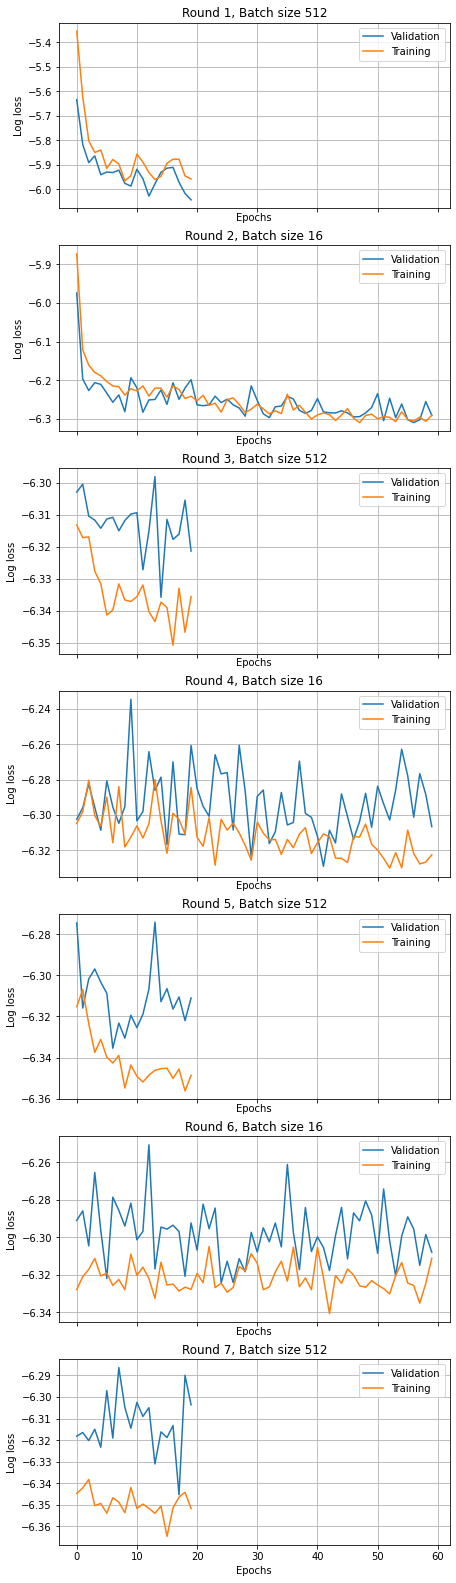

In [25]:
import matplotlib.pyplot as plt
import numpy as np

f, ax = plt.subplots(len(history), 1, figsize=(7, len(history)*4), sharex=True)

for i in range(len(history)):

  ax[i].set_title(titles[i])
  ax[i].plot(history[i].epoch, np.log(history[i].history['val_loss']), label='Validation')
  ax[i].plot(history[i].epoch, np.log(history[i].history['loss']), label='Training')
  ax[i].set_xlabel('Epochs')
  ax[i].set_ylabel('Log loss')
  ax[i].legend()
  ax[i].grid()

In [26]:
encoded_data=pd.DataFrame(vae.encoder.predict(change),
                          index=change.index, columns=['Type'])
New_York_sign = np.sign(encoded_data.loc['New York City, New York','Type'])
if New_York_sign == 1.0:
  encoded_data['Type'] *= -1.0
New_York_sign, encoded_data.loc['New York City, New York','Type']

(-1.0, -2.4484894)

In [27]:
min_x, max_x, grid_n = -3, 3, 401
grid_x = np.linspace(min_x,max_x,grid_n)
decoded=vae.decoder.predict(grid_x)
if New_York_sign == 1.0:
  decoded = np.flip(decoded,axis=0)
decoded.shape

(401, 62)

#### Explore change types

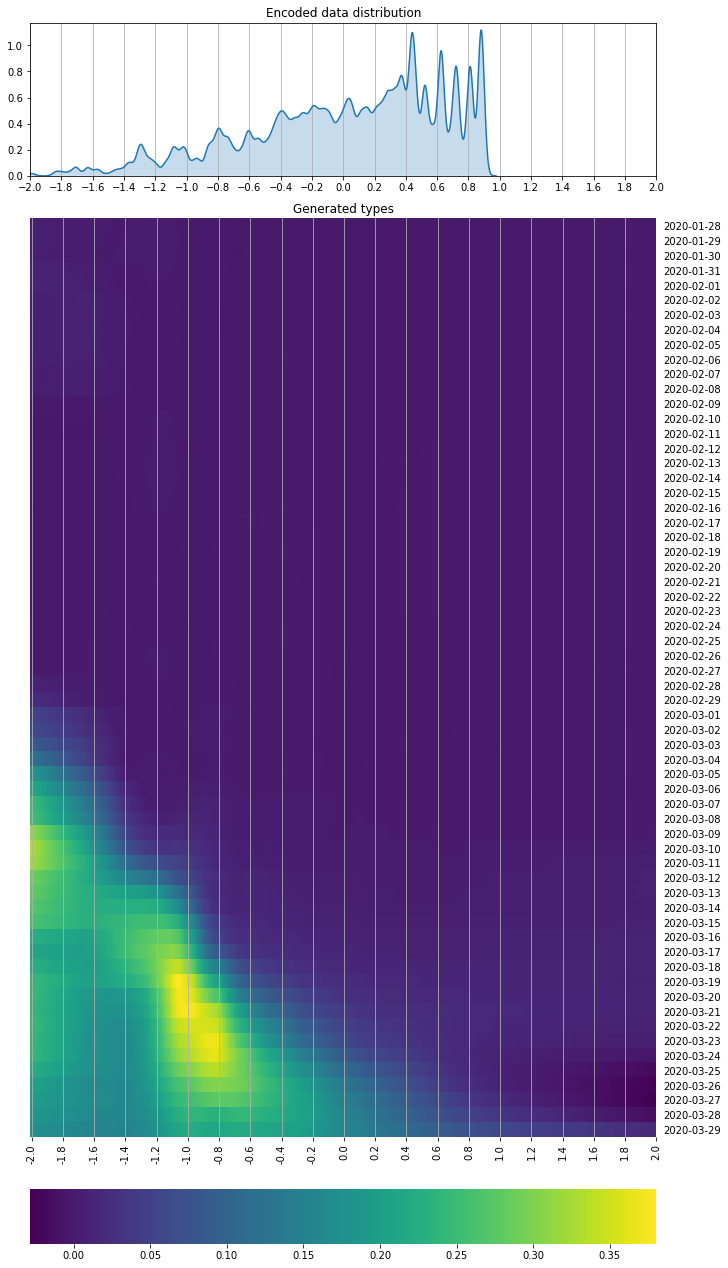

In [28]:
plot_type_dist(encoded_data.values.flatten(), grid_x, decoded, 
               vertical_n=7, feature_labels=change.columns)

plt.savefig('plot_dist_type.png')

In [29]:
change = encoded_data.join(change)

change = change.sort_values(by='Type')

change.to_csv('covid19_confirmed_change.csv')
change

,Type,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29
"Westchester, New York",-2.851717,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.328941,0.412910,0.503766,0.606928,0.629531,0.654995,0.668876,0.356172,0.300977,0.219462,0.134127,0.124485,0.115523,0.179720,0.213153,0.240699,0.276167,0.292605,0.322531,0.368159,0.332358,0.309394,0.286885,0.269200,0.247994,0.216334
"New York City, New York",-2.448489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.099021,0.099021,0.156945,0.156945,0.229920,0.255966,0.366421,0.287843,0.335911,0.362711,0.410240,0.423610,0.465442,0.433353,0.442010,0.442502,0.404745,0.461448,0.462408,0.477364,0.447974,0.472566,0.467972,0.448389,0.386237,0.319512,0.250157,0.228566,0.188174
"Nassau, New York",-2.251414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.099021,0.229920,0.229920,0.255966,0.412910,0.427962,0.481042,0.434932,0.334544,0.396084,0.400480,0.258587,0.269581,0.263949,0.315766,0.382211,0.390971,0.422145,0.442929,0.439895,0.411784,0.332077,0.259946,0.214366,0.174440
"King, Washington",-2.175748,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.099021,0.22992,0.354987,0.396084,0.447928,0.503766,0.567185,0.485885,0.383003,0.290983,0.285442,0.303143,0.276782,0.233644,0.243535,0.239384,0.217602,0.203389,0.142058,0.124460,0.133810,0.125607,0.125067,0.128440,0.123969,0.128847,0.125846,0.117530,0.119182,0.114073,0.105089
"Middlesex, Massachusetts",-2.057904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.099021,0.099021,0.255966,0.342556,0.396084,0.533953,0.533953,0.459839,0.488247,0.342556,0.276120,0.236890,0.108877,0.125350,0.125067,0.123694,0.141733,0.138226,0.145746,0.174357,0.212491,0.214603,0.222021,0.222169,0.227325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Grays Harbor, Washington",0.890626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.099021,0.099021,0.099021,0.099021,0.099021,0.099021,0.099021,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"Charles Mix, South Dakota",0.895288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.099021,0.099021,0.099021,0.099021,0.099021,0.099021,0.099021,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"Ada

In [0]:
def plot_by_code2(data, center=(-5.0,5.0,0.4), width=0.4, max_n=10):
    centers = np.arange(*center)
    decoded_centers=vae.decoder.predict(centers)
    if New_York_sign == 1.0:
      decoded_centers = np.flip(decoded_centers,axis=0)
    decoded_dict = dict(zip(centers,decoded_centers.tolist()))
    sub_df=OrderedDict((centers[i], 
                        data.loc[(data['Type'] >= centers[i]-width/2)
                                  & (data['Type'] <= 
                                     centers[i] + width/2)].iloc[:,1:])
                       for i in range(len(centers)))
    sub_df = OrderedDict(filter(lambda x: len(x[1])>0, sub_df.items()))
    fig, ax = plt.subplots(1,len(sub_df), 
                           figsize = (5*len(sub_df),3.5), 
                           sharey=True)
    for i, center in zip(range(len(sub_df)),sub_df.keys()):
      if len(sub_df[center])>max_n:
        sample = np.random.choice(sub_df[center].shape[0],
                                  size=max_n,replace=False)
        sub_df[center] = sub_df[center].iloc[sample,:]
      #sub_df[center]= sub_df[center]+1
      ax[i].plot(decoded_dict[center],'k')
      ax[i].plot(sub_df[center].T,alpha=0.4)
      ax[i].set_ylabel('7 day average % change')
      ax[i].legend(['Type = {:.2f}'.format(center)] 
                    + sub_df[center].index.tolist(), bbox_to_anchor=(1, -0.3),
                   loc='upper right',borderaxespad=0.)
      #ax[i].set_yscale('log')
      ax[i].set_title('Types {:.2f} to {:.2f}'.format(center - width/2,
                                                      center + width/2))
      ax[i].grid(True)
      ax[i].set_xticks(range(1,sub_df[center].shape[1],7))
      ax[i].tick_params(axis='x',labelrotation=45)

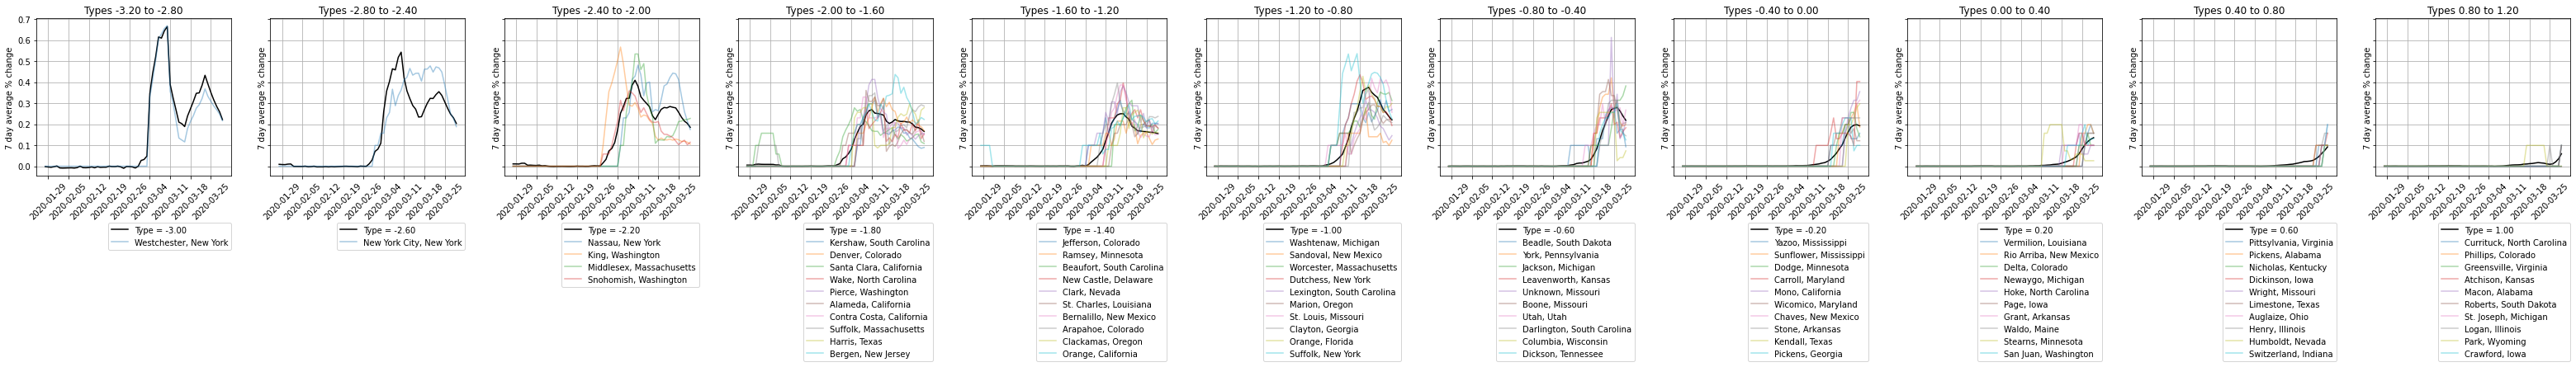

In [73]:
plot_by_code2(change)

plt.savefig('plot_change_by_code.png')

In [32]:
confirmed_by_change = encoded_data.join(confirmed)

confirmed_by_change = confirmed_by_change.sort_values(by='Type')

confirmed_by_change.to_csv('covid19_confirmed_by_change_type.csv')
confirmed_by_change

,Type,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30
"Westchester, New York",-2.851717,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,17.0,33.0,69.0,81.0,97.0,107.0,120.0,147.0,157.0,178.0,195.0,219.0,379.0,537.0,797.0,1091.0,1387.0,1873.0,2894.0,3891.0,4691.0,5944.0,7187.0,7875.0,8519.0,9326.0
"New York City, New York",-2.448489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,4.0,5.0,12.0,14.0,20.0,37.0,52.0,96.0,155.0,269.0,330.0,464.0,645.0,1339.0,2468.0,4408.0,6211.0,9045.0,12305.0,14905.0,20011.0,23112.0,25399.0,30766.0,33768.0,38087.0
"Nassau, New York",-2.251414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,5.0,17.0,19.0,28.0,41.0,51.0,79.0,98.0,109.0,131.0,183.0,382.0,754.0,1234.0,1900.0,2442.0,2869.0,3285.0,3914.0,4657.0,5537.0,6445.0,7344.0
"King, Washington",-2.175748,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,11.0,15.0,22.0,33.0,52.0,59.0,72.0,91.0,117.0,191.0,235.0,271.0,329.0,389.0,421.0,489.0,518.0,563.0,693.0,794.0,935.0,1036.0,1166.0,1278.0,1360.0,1579.0,1830.0,2079.0,2163.0,2332.0
"Middlesex, Massachusetts",-2.057904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,5.0,10.0,15.0,41.0,41.0,49.0,60.0,65.0,75.0,83.0,89.0,100.0,119.0,144.0,177.0,199.0,232.0,304.0,446.0,538.0,685.0,842.0,981.0,1141.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Grays Harbor, Washington",0.890626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"Charles Mix, South Dakota",0.895288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"Adams, Indiana",0.895288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"Charlton, Georgia",0.895288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [0]:
def plot_by_code3(data, center=(-5.0,5.0,0.4), width=0.4, max_n=10):
    centers = np.arange(*center)
    decoded_centers=vae.decoder.predict(centers)
    if New_York_sign == 1.0:
      decoded_centers = np.flip(decoded_centers,axis=0)
    decoded_centers = np.concatenate([np.zeros((decoded_centers.shape[0],4)),
                                    decoded_centers], axis=1)
    decoded_centers = np.concatenate([decoded_centers,
                                  np.tile(decoded_centers[:,-1]\
                                          .reshape((decoded_centers.shape[0],1)),3)],
                                  axis=1)
    decoded_centers = np.cumsum(decoded_centers, axis=1)
    decoded_centers = np.exp(decoded_centers)    
    decoded_dict = dict(zip(centers,decoded_centers.tolist()))
    sub_df=OrderedDict((centers[i], 
                        data.loc[(data['Type'] >= centers[i]-width/2)
                                  & (data['Type'] <= 
                                     centers[i] + width/2)].iloc[:,1:])
                       for i in range(len(centers)))
    sub_df = OrderedDict(filter(lambda x: len(x[1])>0, sub_df.items()))
    fig, ax = plt.subplots(1,len(sub_df), 
                           figsize = (5*len(sub_df),3.5), 
                           sharey=True)
    for i, center in zip(range(len(sub_df)),sub_df.keys()):
      if len(sub_df[center])>max_n:
        sample = np.random.choice(sub_df[center].shape[0],
                                  size=max_n,replace=False)
        sub_df[center] = sub_df[center].iloc[sample,:]
      sub_df[center]= sub_df[center]+1
      ax[i].plot(decoded_dict[center],'k')
      ax[i].plot(sub_df[center].T, alpha=0.4)
      ax[i].set_ylabel('Confirmed cases')
      ax[i].legend(['Type = {:.2f}'.format(center)] 
                    + sub_df[center].index.tolist(), bbox_to_anchor=(1, -0.3),
                   loc='upper right',borderaxespad=0.)
      ax[i].set_yscale('log')
      ax[i].set_title('Types {:.2f} to {:.2f}'.format(center - width/2,
                                                      center + width/2))
      ax[i].grid(True)
      ax[i].set_xticks(range(1,sub_df[center].shape[1],7))
      ax[i].tick_params(axis='x',labelrotation=45)

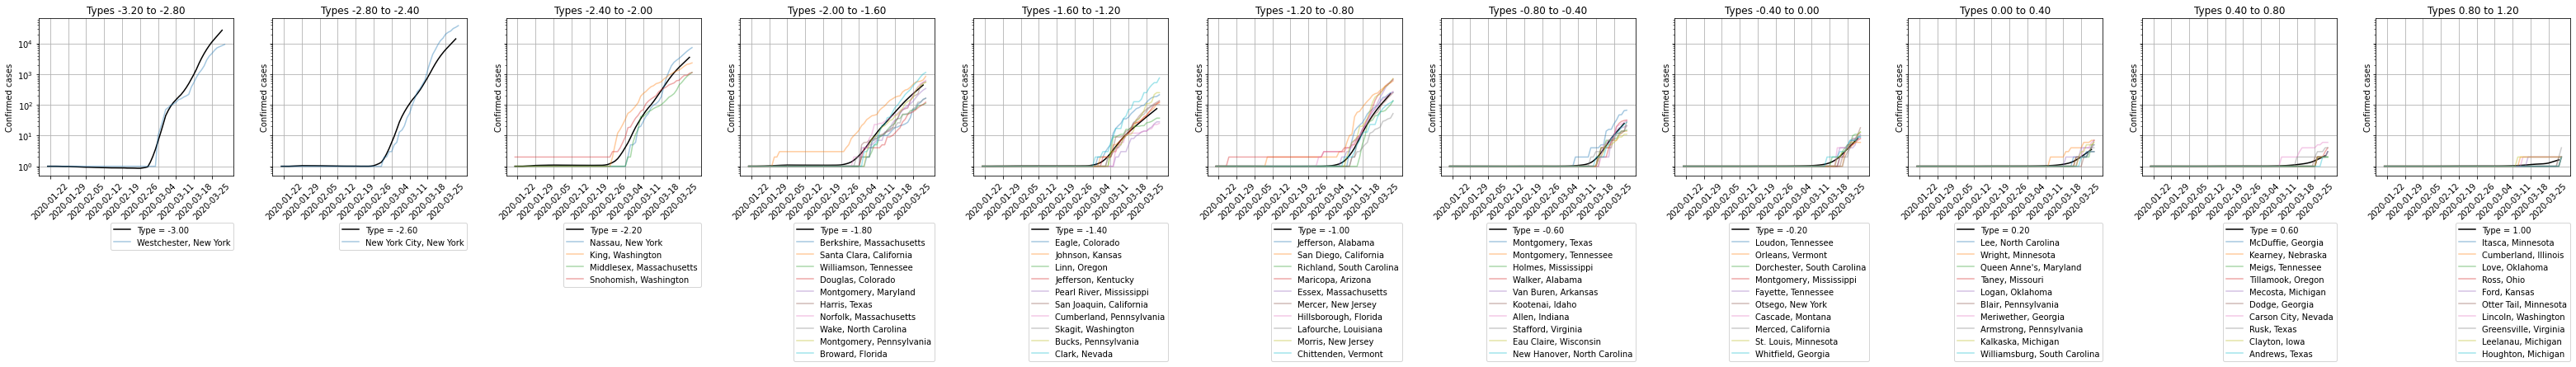

In [74]:
plot_by_code3(confirmed_by_change)

plt.savefig('plot_confirmed_by_change_code.png')